In [ ]:
# %%
import tensorcircuit as tc
# import pennylane as qml
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split,Subset
import random
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import csv
import tensorflow as tf


data_path = 'E:\\Test\\VsCode_Test\\Jupyter notebook\\zemp\\xLw\\data'

val_num = 200
data_num =  1200           # 需要划分的数据集大小
epochs = 20                 # 迭代轮次数
batch_size = 32

K = tc.set_backend("tensorflow")
# 归一化处理
def trans(x):
    x = np.array(x)
    x = x/255.0
    # print(x.shape)    
    return torch.from_numpy(x).float()  # 将 NumPy 数组 x 转换为 PyTorch 张量

transform = transforms.Compose([
    transforms.Resize((14, 14)),                # 将图片缩小为 14x14
    transforms.Lambda(lambda x:trans(x))
])

# 加载MNIST数据集 28X28X1   10类别   
trainset = torchvision.datasets.FashionMNIST(root=data_path, train=True,
                                        download=False, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_path, train=False,
                                        download=False, transform=transform)

# 随机抽取训练集 data_num 张图片作为子集
subset_indices = random.sample(range(len(trainset)), k=data_num)
train_subset = Subset(trainset, subset_indices)

# 随机抽取测试集 data_num 张图片作为子集
subset_val = random.sample(range(len(testset)), k=val_num)
val_subset = Subset(testset, subset_val)

# 加载测试集
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size,  # type: ignore
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size,    # type: ignore
                                         shuffle=False)

# %%
n = 4
nlayers = 1

# 我们定义量子函数，
# 注意这个函数是在 tensorflow 上运行的
def qpred(x, weights):
    c = tc.Circuit(n)
    for i in range(n):
        c.h(i)
        c.ry(i,theta=x[i]*weights[i])
    for i in range(n):
        c.crx(i,(i+1)%4,theta=weights[i+4])
    return [K.real(c.expectation([tc.gates.z(), [i]])) for i in range(n)]

# %%
qpred_vmap = K.vmap(qpred, vectorized_argnums=0)        # `qpred_vmap` 是一个具有向量化能力的 TensorFlow 函数
qpred_batch = tc.interfaces.torch_interface(qpred_vmap, jit=True) # 我们进一步将函数包装为 PyTorch 函数

# %%
class QuantumNetV2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.q_weights = torch.nn.Parameter(torch.randn([n*2]))
        self.stride = 1
        self.padding_s = 2

    def forward(self, inputs):

        in_bs,in_ch,in_w,in_h = inputs.shape

        kernel_size = 2
        # 判断输入的步长S是多少再决定是否填充
        # padding_input_inside = self.padding_s - 1
        padding_size = kernel_size - 1                              # 边界填充数 14+13=27

        padding_temp = nn.functional.pad(inputs,(13,0,13,0),mode='constant',value=0)
        # print(padding_temp.shape) # 输出 27*27
        
        # 元素间填充
        for bs in range(in_bs):
            for ch in range(in_ch):
                for i in range(in_w):     # 14是输入图片大小
                    for j in range(in_h):
                        padding_temp[bs,ch,i*2,j*2] = inputs[bs,ch,i,j]   # 对原图像（14X14）进行内部空洞
        # print(padding_temp)
        # print(padding_temp.shape)       # torch.Size([32, 1, 27, 27])                                                                                                                                                                                                                            

        # 使用转置卷积进行上采样，作为转置卷积的输入
        padd_img = nn.functional.pad(padding_temp,(padding_size,padding_size,padding_size,padding_size),mode='constant',value=0)
        # print(padd_img.shape)   # torch.Size([32, 1, 29, 29])
        
        bs, ch , h , w = padd_img.size()                      #    h=29
        
        # 转置卷积后输出特征图的大小
        h_out = self.padding_s*(in_h-1)+kernel_size           #   2（14-1）+ 2 = 28
        w_out = self.padding_s*(in_w-1)+kernel_size           #   2（14-1）+ 2 = 28

        out = torch.zeros((bs,4, h_out, w_out))
        for b in range(bs):
                for j in range(0, h_out, self.stride):
                    for k in range(0, w_out, self.stride):
                        # print(f'padd_img[b, 0, j, k]={padd_img[b, 0, j, k].shape}')
                        t1 = padd_img[b, 0, j, k]        
                        t2 = padd_img[b, 0, j, k + 1]
                        t3 = padd_img[b, 0, j + 1, k]    
                        t4 = padd_img[b, 0, j + 1, k + 1]

                        temp = torch.Tensor([t1,t2,t3,t4]) # 
                        temp = temp.view(1,4)
    
                        q_results = qpred_batch(temp, self.q_weights)     
                        for c in range(4):
                            out[b, c,j // kernel_size, k // kernel_size] = q_results[c]
        return out

# %%
# 经典CNNmodel 可进行修改
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
            
        # Quantum layer 1
        self.conv1 = QuantumNetV2()
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm2d(4)  # 4
        
        # Fully-Connected layer 2
        self.fc2 = nn.Linear(3136,10)
                
    def forward(self, x):

        # qconv layer 1
        out = self.conv1(x)                 
        out = self.relu1(out)   
        out = self.batch1(out)
        
        #Flatten拉平操作
        out = out.view(out.size(0),-1)      # print(f'-----拉平后的维度是--{out.shape}') #  torch.Size([64, 576])
        
        #FC 第二层
        out = self.fc2(out)
        return F.log_softmax(out,dim = 1)

# %%
model = CNNModel()
loss_fun = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

# %%
# 准确率计算
def accuracy(output,labels):
    prediction = torch.max(output.data,1)[1]
    rights = prediction.eq(labels.data.view_as(prediction)).sum()
    return rights,len(labels)

# 绘制训练结果
def draw_result(accs,losses,title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6))   # subplots创建1行 2列的子图
    
    ax1.plot(losses) 
    ax1.set_title(title+" Loss")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss")
    
    ax2.plot(accs)
    ax2.set_title(title+" Accuracy")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Accuracy")

# %%
def train(epochs,model,loss_fun,opt,train_loader,test_loader):
    train_accuracy = []             # 训练集准确率
    train_loss = []

    val_accuracy = []               # 验证集准确率
    val_loss = []
    for epoch in range(epochs):
                ### 训练模块
        train_total_accuracy = 0    # 训练集每epoch（18个batch的和）的准确率
        train_total_loss = 0
        for batch_idx,(data,labels) in enumerate(train_loader):
            t2 = time.time()
            data = data.view(data.shape[0],1, data.shape[1], data.shape[2])
            # print(data)
            model.train()					    # 1 模型训练       
            output = model(data)			    # 2 模型输出
            # print(f'output.shape is {output.shape}')    # output.shape is torch.Size([64, 4, 17, 17])
            # print(f'labels.shape is {labels.shape}')    # labels.shape is torch.Size([64])
            loss = loss_fun(output,labels)	    # 3 计算损失

            opt.zero_grad()					    # 4 梯度清零
            loss.backward() 				    # 5 开始反向传播
            opt.step()                          # 6 梯度更新
            
            # 计算准确率
            accuracy_count, total_count = accuracy(output,labels)
            accuracy_rate = accuracy_count / total_count  # 计算准确率（预测正确的样本数除以总样本数）

            train_total_accuracy += accuracy_count
            train_total_loss +=loss.item()

            batch_time = time.time()-t2
            print(f'Epoch:{epoch}---batch({batch_idx})训练集---ACC:{accuracy_rate:.2%}---LOSS:{loss.item():.3f}---time:{batch_time:.2f}')        
        
        train_total_loss /= batch_idx+1
        train_accuracy.append(train_total_accuracy/len(train_subset))   # 保存1轮的数据 len(train_accuracy)
        train_loss.append(train_total_loss)
### 验证模块
        total_acc = 0
        total_test_loss = 0
        model.eval()
        with torch.no_grad():# 进行评测的时候网络不更新梯度
            for step,(data,target) in enumerate(test_loader):
                data = data.view(data.shape[0],1, data.shape[1], data.shape[2])            # 调整维度一致
                outputs = model(data)
                losses = loss_fun(outputs,target)                               # 计算损失

                accuracy_count, total_count = accuracy(outputs,target)          # 计算准确率
                accuracy_rate = accuracy_count / total_count                    # 计算准确率（预测正确的样本数除以总样本数）

                total_acc += accuracy_count
                total_test_loss+=losses.item()

        total_test_loss /= step + 1
        val_accuracy.append((total_acc/len(val_subset)))
        val_loss.append(total_test_loss)
        print(f'第{epoch}轮测试集准确率：{total_acc/len(val_subset):.2%}....测试集Loss:{total_test_loss}')
    
    ### 画出训练结果图 ##############
    draw_result(train_accuracy,train_loss,"Train")
    draw_result(val_accuracy,val_loss,"Val")
    
    ####  训练的结果写入文件   ##############
    with open(str(random.randint(100,999))+"_train.csv",mode='w',newline='') as file:         # newline='' 指定行与行之间的分隔符，每一行都将以换行符（'\n'）作为分隔符
        wirter = csv.writer(file)                               # 以视图模式打开csv文件
        wirter.writerow(['Epoch','Train_loss','Train_acc'])     # 将一行数据写入csv文件中，这里写入标题行
        for i in range(epochs):                                 # 写入数据行
            wirter.writerow([i, train_loss[i], train_accuracy[i].numpy()])
    
    #### 测试的结果写入文件  ##############
    with open(str(random.randint(1000,9999))+"_val.csv",mode='w',newline='') as file:         # newline='' 指定行与行之间的分隔符，每一行都将以换行符（'\n'）作为分隔符
        wirter = csv.writer(file)                               # 以视图模式打开csv文件
        wirter.writerow(['Epoch','Val_loss','Val_acc'])     # 将一行数据写入csv文件中，这里写入标题行
        for i in range(epochs):                                 # 写入数据行
            wirter.writerow([i, val_loss[i], val_accuracy[i].numpy()])

    ### 保存训练的结果
    # Loss0 = torch.tensor(save_train_loss)
    # torch.save(Loss0,'E:\\Test\\VsCode_Test\\Python\\xlw\\test1\\lw2\\epoch_{}'.format(epochs))
    return model, train_accuracy,train_loss


model, train_accuracy,train_loss = train(epochs,model,loss_fun,opt,trainloader,testloader)


Epoch:0---batch(0)训练集---ACC:18.75%---LOSS:2.241---time:47.80
Epoch:0---batch(1)训练集---ACC:15.62%---LOSS:12.049---time:44.36
Epoch:0---batch(2)训练集---ACC:15.62%---LOSS:5.541---time:44.44
Epoch:0---batch(3)训练集---ACC:28.12%---LOSS:6.815---time:44.59
Epoch:0---batch(4)训练集---ACC:6.25%---LOSS:10.044---time:44.47
Epoch:0---batch(5)训练集---ACC:43.75%---LOSS:3.984---time:44.69
Epoch:0---batch(6)训练集---ACC:21.88%---LOSS:7.787---time:45.17
Epoch:0---batch(7)训练集---ACC:21.88%---LOSS:8.075---time:45.01
Epoch:0---batch(8)训练集---ACC:25.00%---LOSS:6.864---time:45.02
Epoch:0---batch(9)训练集---ACC:28.12%---LOSS:5.885---time:44.57
Epoch:0---batch(10)训练集---ACC:31.25%---LOSS:3.033---time:44.27
Epoch:0---batch(11)训练集---ACC:21.88%---LOSS:2.257---time:44.37
Epoch:0---batch(12)训练集---ACC:50.00%---LOSS:3.098---time:44.13
Epoch:0---batch(13)训练集---ACC:40.62%---LOSS:4.043---time:44.17
Epoch:0---batch(14)训练集---ACC:56.25%---LOSS:3.403---time:44.63
Epoch:0---batch(15)训练集---ACC:50.00%---LOSS:2.813---time:44.52
Epoch:0---batch(16)训练集---ACC:53.12%---LOSS:1.977---time:44.43
Epoch:0---batch(17)训练集---ACC:56.25%---LOSS:1.255---time:44.17
Epoch:0---batch(18)训练集---ACC:43.75%---LOSS:1.649---time:43.54
Epoch:0---batch(19)训练集---ACC:37.50%---LOSS:2.338---time:44.48
Epoch:0---batch(20)训练集---ACC:43.75%---LOSS:1.837---time:44.49
Epoch:0---batch(21)训练集---ACC:40.62%---LOSS:2.140---time:44.21
Epoch:0---batch(22)训练集---ACC:50.00%---LOSS:1.723---time:45.45
Epoch:0---batch(23)训练集---ACC:56.25%---LOSS:1.963---time:43.96
Epoch:0---batch(24)训练集---ACC:65.62%---LOSS:1.187---time:44.28
Epoch:0---batch(25)训练集---ACC:53.12%---LOSS:2.081---time:44.04
Epoch:0---batch(26)训练集---ACC:50.00%---LOSS:1.426---time:44.74
Epoch:0---batch(27)训练集---ACC:40.62%---LOSS:1.471---time:44.12
Epoch:0---batch(28)训练集---ACC:53.12%---LOSS:1.361---time:44.70
Epoch:0---batch(29)训练集---ACC:50.00%---LOSS:1.272---time:43.98
Epoch:0---batch(30)训练集---ACC:59.38%---LOSS:1.193---time:44.50
Epoch:0---batch(31)训练集---ACC:78.12%---LOSS:0.760---time:44.35
Epoch:0---batch(32)训练集---ACC:62.50%---LOSS:0.970---time:44.23
Epoch:0---batch(33)训练集---ACC:84.38%---LOSS:0.645---time:44.25
Epoch:0---batch(34)训练集---ACC:78.12%---LOSS:0.978---time:44.56
Epoch:0---batch(35)训练集---ACC:71.88%---LOSS:1.197---time:44.63
Epoch:0---batch(36)训练集---ACC:65.62%---LOSS:1.632---time:44.46
Epoch:0---batch(37)训练集---ACC:56.25%---LOSS:0.979---time:22.09
第0轮测试集准确率：16.00%....测试集Loss:2.423792907169887
Epoch:1---batch(0)训练集---ACC:53.12%---LOSS:1.360---time:44.04
Epoch:1---batch(1)训练集---ACC:59.38%---LOSS:1.134---time:44.24
Epoch:1---batch(2)训练集---ACC:50.00%---LOSS:1.347---time:43.98
Epoch:1---batch(3)训练集---ACC:65.62%---LOSS:0.804---time:44.38
Epoch:1---batch(4)训练集---ACC:62.50%---LOSS:0.957---time:44.41
Epoch:1---batch(5)训练集---ACC:68.75%---LOSS:1.038---time:44.59
Epoch:1---batch(6)训练集---ACC:75.00%---LOSS:1.043---time:44.22
Epoch:1---batch(7)训练集---ACC:65.62%---LOSS:1.015---time:44.19
Epoch:1---batch(8)训练集---ACC:68.75%---LOSS:0.988---time:44.18
Epoch:1---batch(9)训练集---ACC:59.38%---LOSS:1.109---time:44.45
Epoch:1---batch(10)训练集---ACC:59.38%---LOSS:1.056---time:44.50
Epoch:1---batch(11)训练集---ACC:56.25%---LOSS:1.052---time:44.38
Epoch:1---batch(12)训练集---ACC:78.12%---LOSS:0.475---time:44.56
Epoch:1---batch(13)训练集---ACC:62.50%---LOSS:0.805---time:44.42
Epoch:1---batch(14)训练集---ACC:59.38%---LOSS:0.990---time:44.25
Epoch:1---batch(15)训练集---ACC:68.75%---LOSS:1.220---time:44.04
Epoch:1---batch(16)训练集---ACC:75.00%---LOSS:0.865---time:44.23
Epoch:1---batch(17)训练集---ACC:65.62%---LOSS:0.956---time:44.49
Epoch:1---batch(18)训练集---ACC:68.75%---LOSS:1.135---time:43.94
Epoch:1---batch(19)训练集---ACC:62.50%---LOSS:0.968---time:44.46
Epoch:1---batch(20)训练集---ACC:75.00%---LOSS:0.649---time:44.03
Epoch:1---batch(21)训练集---ACC:71.88%---LOSS:0.748---time:44.44
Epoch:1---batch(22)训练集---ACC:62.50%---LOSS:0.981---time:44.08
Epoch:1---batch(23)训练集---ACC:68.75%---LOSS:0.902---time:44.46
Epoch:1---batch(24)训练集---ACC:56.25%---LOSS:1.028---time:44.08
Epoch:1---batch(25)训练集---ACC:68.75%---LOSS:0.841---time:44.43
Epoch:1---batch(26)训练集---ACC:84.38%---LOSS:0.666---time:44.31
Epoch:1---batch(27)训练集---ACC:68.75%---LOSS:0.976---time:44.06
Epoch:1---batch(28)训练集---ACC:78.12%---LOSS:0.822---time:44.34
Epoch:1---batch(29)训练集---ACC:62.50%---LOSS:0.883---time:43.94
Epoch:1---batch(30)训练集---ACC:75.00%---LOSS:0.656---time:44.16
Epoch:1---batch(31)训练集---ACC:62.50%---LOSS:0.958---time:44.01
Epoch:1---batch(32)训练集---ACC:71.88%---LOSS:0.673---time:43.99
Epoch:1---batch(33)训练集---ACC:71.88%---LOSS:0.677---time:44.14
Epoch:1---batch(34)训练集---ACC:75.00%---LOSS:0.560---time:44.00
Epoch:1---batch(35)训练集---ACC:71.88%---LOSS:0.874---time:43.80
Epoch:1---batch(36)训练集---ACC:56.25%---LOSS:1.306---time:43.96
Epoch:1---batch(37)训练集---ACC:75.00%---LOSS:1.115---time:22.08
第1轮测试集准确率：66.50%....测试集Loss:0.8856911914689201
Epoch:2---batch(0)训练集---ACC:65.62%---LOSS:1.002---time:44.25
Epoch:2---batch(1)训练集---ACC:68.75%---LOSS:0.619---time:43.69
Epoch:2---batch(2)训练集---ACC:59.38%---LOSS:0.977---time:44.23
Epoch:2---batch(3)训练集---ACC:71.88%---LOSS:0.767---time:44.05
Epoch:2---batch(4)训练集---ACC:65.62%---LOSS:0.673---time:44.08
Epoch:2---batch(5)训练集---ACC:75.00%---LOSS:0.644---time:45.99
Epoch:2---batch(6)训练集---ACC:75.00%---LOSS:0.624---time:44.08
Epoch:2---batch(7)训练集---ACC:59.38%---LOSS:0.882---time:44.25
Epoch:2---batch(8)训练集---ACC:75.00%---LOSS:0.754---time:44.00
Epoch:2---batch(9)训练集---ACC:68.75%---LOSS:0.764---time:44.11
Epoch:2---batch(10)训练集---ACC:68.75%---LOSS:1.049---time:44.34
Epoch:2---batch(11)训练集---ACC:78.12%---LOSS:0.926---time:44.17
Epoch:2---batch(12)训练集---ACC:59.38%---LOSS:0.883---time:43.90
Epoch:2---batch(13)训练集---ACC:65.62%---LOSS:1.082---time:44.00
Epoch:2---batch(14)训练集---ACC:68.75%---LOSS:0.947---time:43.81
Epoch:2---batch(15)训练集---ACC:84.38%---LOSS:0.509---time:43.90
Epoch:2---batch(16)训练集---ACC:65.62%---LOSS:1.019---time:43.99
Epoch:2---batch(17)训练集---ACC:78.12%---LOSS:0.683---time:43.75
Epoch:2---batch(18)训练集---ACC:62.50%---LOSS:0.843---time:44.27
Epoch:2---batch(19)训练集---ACC:71.88%---LOSS:0.709---time:43.84
Epoch:2---batch(20)训练集---ACC:78.12%---LOSS:0.584---time:43.82
Epoch:2---batch(21)训练集---ACC:62.50%---LOSS:1.143---time:44.09
Epoch:2---batch(22)训练集---ACC:68.75%---LOSS:0.877---time:44.22
Epoch:2---batch(23)训练集---ACC:78.12%---LOSS:0.538---time:44.09
Epoch:2---batch(24)训练集---ACC:84.38%---LOSS:0.362---time:44.41
Epoch:2---batch(25)训练集---ACC:68.75%---LOSS:0.898---time:44.24
Epoch:2---batch(26)训练集---ACC:71.88%---LOSS:0.923---time:44.40
Epoch:2---batch(27)训练集---ACC:68.75%---LOSS:0.754---time:44.10
Epoch:2---batch(28)训练集---ACC:50.00%---LOSS:1.500---time:43.97
Epoch:2---batch(29)训练集---ACC:81.25%---LOSS:0.722---time:44.18
Epoch:2---batch(30)训练集---ACC:81.25%---LOSS:0.699---time:43.89
Epoch:2---batch(31)训练集---ACC:62.50%---LOSS:1.235---time:44.32
Epoch:2---batch(32)训练集---ACC:81.25%---LOSS:0.891---time:43.32
Epoch:2---batch(33)训练集---ACC:75.00%---LOSS:0.829---time:43.82
Epoch:2---batch(34)训练集---ACC:75.00%---LOSS:0.475---time:43.80
Epoch:2---batch(35)训练集---ACC:71.88%---LOSS:1.209---time:43.69
Epoch:2---batch(36)训练集---ACC:81.25%---LOSS:0.604---time:44.11
Epoch:2---batch(37)训练集---ACC:62.50%---LOSS:0.838---time:22.04
第2轮测试集准确率：66.00%....测试集Loss:0.8899965286254883
Epoch:3---batch(0)训练集---ACC:65.62%---LOSS:1.116---time:44.10
Epoch:3---batch(1)训练集---ACC:68.75%---LOSS:0.889---time:43.87
Epoch:3---batch(2)训练集---ACC:68.75%---LOSS:1.001---time:43.87
Epoch:3---batch(3)训练集---ACC:71.88%---LOSS:0.714---time:44.10
Epoch:3---batch(4)训练集---ACC:71.88%---LOSS:0.919---time:44.14
Epoch:3---batch(5)训练集---ACC:62.50%---LOSS:1.097---time:43.91
Epoch:3---batch(6)训练集---ACC:75.00%---LOSS:0.781---time:44.31
Epoch:3---batch(7)训练集---ACC:71.88%---LOSS:0.669---time:43.64
Epoch:3---batch(8)训练集---ACC:65.62%---LOSS:0.610---time:44.49
Epoch:3---batch(9)训练集---ACC:81.25%---LOSS:0.474---time:44.04
Epoch:3---batch(10)训练集---ACC:62.50%---LOSS:0.707---time:43.94
Epoch:3---batch(11)训练集---ACC:53.12%---LOSS:1.306---time:44.07
Epoch:3---batch(12)训练集---ACC:68.75%---LOSS:0.790---time:44.26
Epoch:3---batch(13)训练集---ACC:81.25%---LOSS:0.597---time:44.18
Epoch:3---batch(14)训练集---ACC:75.00%---LOSS:0.673---time:44.26
Epoch:3---batch(15)训练集---ACC:75.00%---LOSS:0.842---time:44.64
Epoch:3---batch(16)训练集---ACC:81.25%---LOSS:0.540---time:44.03
Epoch:3---batch(17)训练集---ACC:84.38%---LOSS:0.593---time:43.73
Epoch:3---batch(18)训练集---ACC:81.25%---LOSS:0.570---time:43.99
Epoch:3---batch(19)训练集---ACC:59.38%---LOSS:0.823---time:44.22
Epoch:3---batch(20)训练集---ACC:75.00%---LOSS:0.761---time:44.11
Epoch:3---batch(21)训练集---ACC:65.62%---LOSS:0.727---time:44.08
Epoch:3---batch(22)训练集---ACC:62.50%---LOSS:0.743---time:44.06
Epoch:3---batch(23)训练集---ACC:78.12%---LOSS:0.626---time:43.99
Epoch:3---batch(24)训练集---ACC:87.50%---LOSS:0.565---time:43.92
Epoch:3---batch(25)训练集---ACC:81.25%---LOSS:0.667---time:43.96
Epoch:3---batch(26)训练集---ACC:65.62%---LOSS:0.800---time:44.17
Epoch:3---batch(27)训练集---ACC:68.75%---LOSS:0.881---time:44.02
Epoch:3---batch(28)训练集---ACC:53.12%---LOSS:1.206---time:44.13
Epoch:3---batch(29)训练集---ACC:81.25%---LOSS:0.492---time:44.01
Epoch:3---batch(30)训练集---ACC:68.75%---LOSS:0.562---time:44.05
Epoch:3---batch(31)训练集---ACC:78.12%---LOSS:0.769---time:44.21
Epoch:3---batch(32)训练集---ACC:75.00%---LOSS:0.701---time:44.37
Epoch:3---batch(33)训练集---ACC:50.00%---LOSS:0.945---time:43.73
Epoch:3---batch(34)训练集---ACC:78.12%---LOSS:0.737---time:44.21
Epoch:3---batch(35)训练集---ACC:56.25%---LOSS:1.263---time:44.25
Epoch:3---batch(36)训练集---ACC:78.12%---LOSS:0.967---time:43.67
Epoch:3---batch(37)训练集---ACC:81.25%---LOSS:0.506---time:22.05
第3轮测试集准确率：69.50%....测试集Loss:0.9948422142437526
Epoch:4---batch(0)训练集---ACC:71.88%---LOSS:0.460---time:44.16
Epoch:4---batch(1)训练集---ACC:68.75%---LOSS:0.801---time:43.75
Epoch:4---batch(2)训练集---ACC:71.88%---LOSS:0.659---time:44.09
Epoch:4---batch(3)训练集---ACC:71.88%---LOSS:0.579---time:44.08
Epoch:4---batch(4)训练集---ACC:62.50%---LOSS:1.135---time:44.28
Epoch:4---batch(5)训练集---ACC:62.50%---LOSS:1.116---time:44.38
Epoch:4---batch(6)训练集---ACC:78.12%---LOSS:0.913---time:43.56
Epoch:4---batch(7)训练集---ACC:84.38%---LOSS:0.625---time:43.90
Epoch:4---batch(8)训练集---ACC:75.00%---LOSS:0.540---time:43.90
Epoch:4---batch(9)训练集---ACC:68.75%---LOSS:1.008---time:43.89
Epoch:4---batch(10)训练集---ACC:78.12%---LOSS:0.774---time:44.14
Epoch:4---batch(11)训练集---ACC:71.88%---LOSS:0.637---time:43.91
Epoch:4---batch(12)训练集---ACC:53.12%---LOSS:1.292---time:43.99
Epoch:4---batch(13)训练集---ACC:75.00%---LOSS:0.601---time:43.85
Epoch:4---batch(14)训练集---ACC:65.62%---LOSS:1.078---time:44.01
Epoch:4---batch(15)训练集---ACC:78.12%---LOSS:0.629---time:43.88
Epoch:4---batch(16)训练集---ACC:71.88%---LOSS:0.702---time:44.05
Epoch:4---batch(17)训练集---ACC:81.25%---LOSS:0.547---time:44.15
Epoch:4---batch(18)训练集---ACC:62.50%---LOSS:1.256---time:44.11
Epoch:4---batch(19)训练集---ACC:53.12%---LOSS:1.112---time:43.74
Epoch:4---batch(20)训练集---ACC:65.62%---LOSS:1.054---time:44.00
Epoch:4---batch(21)训练集---ACC:68.75%---LOSS:0.737---time:43.79
Epoch:4---batch(22)训练集---ACC:71.88%---LOSS:0.773---time:43.93
Epoch:4---batch(23)训练集---ACC:68.75%---LOSS:0.679---time:44.09
Epoch:4---batch(24)训练集---ACC:78.12%---LOSS:0.598---time:44.01
Epoch:4---batch(25)训练集---ACC:87.50%---LOSS:0.365---time:43.74
Epoch:4---batch(26)训练集---ACC:75.00%---LOSS:0.482---time:44.06
Epoch:4---batch(27)训练集---ACC:71.88%---LOSS:0.752---time:43.99
Epoch:4---batch(28)训练集---ACC:84.38%---LOSS:0.370---time:43.85
Epoch:4---batch(29)训练集---ACC:78.12%---LOSS:0.602---time:44.24
Epoch:4---batch(30)训练集---ACC:78.12%---LOSS:0.498---time:44.07
Epoch:4---batch(31)训练集---ACC:68.75%---LOSS:0.694---time:44.42
Epoch:4---batch(32)训练集---ACC:81.25%---LOSS:0.546---time:44.36
Epoch:4---batch(33)训练集---ACC:71.88%---LOSS:0.636---time:44.25
Epoch:4---batch(34)训练集---ACC:75.00%---LOSS:0.579---time:44.16
Epoch:4---batch(35)训练集---ACC:78.12%---LOSS:0.566---time:43.75
Epoch:4---batch(36)训练集---ACC:78.12%---LOSS:0.636---time:44.09
Epoch:4---batch(37)训练集---ACC:81.25%---LOSS:0.974---time:21.87
第4轮测试集准确率：78.00%....测试集Loss:0.7102782939161573
Epoch:5---batch(0)训练集---ACC:68.75%---LOSS:0.781---time:43.96
Epoch:5---batch(1)训练集---ACC:90.62%---LOSS:0.503---time:44.19
Epoch:5---batch(2)训练集---ACC:78.12%---LOSS:0.576---time:44.07
Epoch:5---batch(3)训练集---ACC:75.00%---LOSS:0.570---time:43.78
Epoch:5---batch(4)训练集---ACC:81.25%---LOSS:0.630---time:43.76
Epoch:5---batch(5)训练集---ACC:71.88%---LOSS:0.685---time:43.73
Epoch:5---batch(6)训练集---ACC:84.38%---LOSS:0.405---time:44.41
Epoch:5---batch(7)训练集---ACC:71.88%---LOSS:0.901---time:44.24
Epoch:5---batch(8)训练集---ACC:75.00%---LOSS:0.617---time:44.18
Epoch:5---batch(9)训练集---ACC:84.38%---LOSS:0.493---time:44.20
Epoch:5---batch(10)训练集---ACC:75.00%---LOSS:0.725---time:44.05
Epoch:5---batch(11)训练集---ACC:65.62%---LOSS:1.162---time:44.10
Epoch:5---batch(12)训练集---ACC:71.88%---LOSS:0.777---time:44.23
Epoch:5---batch(13)训练集---ACC:71.88%---LOSS:0.716---time:44.10
Epoch:5---batch(14)训练集---ACC:65.62%---LOSS:1.168---time:44.22
Epoch:5---batch(15)训练集---ACC:78.12%---LOSS:0.559---time:43.88
Epoch:5---batch(16)训练集---ACC:71.88%---LOSS:0.622---time:43.86
Epoch:5---batch(17)训练集---ACC:78.12%---LOSS:0.592---time:44.23
Epoch:5---batch(18)训练集---ACC:75.00%---LOSS:0.624---time:43.73
Epoch:5---batch(19)训练集---ACC:78.12%---LOSS:0.490---time:44.04
Epoch:5---batch(20)训练集---ACC:75.00%---LOSS:0.904---time:43.63
Epoch:5---batch(21)训练集---ACC:68.75%---LOSS:0.877---time:44.05
Epoch:5---batch(22)训练集---ACC:87.50%---LOSS:0.325---time:43.80
Epoch:5---batch(23)训练集---ACC:68.75%---LOSS:0.962---time:44.30
Epoch:5---batch(24)训练集---ACC:75.00%---LOSS:0.664---time:43.93
Epoch:5---batch(25)训练集---ACC:81.25%---LOSS:0.627---time:43.43
Epoch:5---batch(26)训练集---ACC:84.38%---LOSS:0.389---time:44.04
Epoch:5---batch(27)训练集---ACC:78.12%---LOSS:0.491---time:43.99
Epoch:5---batch(28)训练集---ACC:68.75%---LOSS:0.884---time:44.13
Epoch:5---batch(29)训练集---ACC:87.50%---LOSS:0.356---time:43.77
Epoch:5---batch(30)训练集---ACC:84.38%---LOSS:0.478---time:44.45
Epoch:5---batch(31)训练集---ACC:78.12%---LOSS:0.571---time:43.57
Epoch:5---batch(32)训练集---ACC:68.75%---LOSS:0.936---time:43.84
Epoch:5---batch(33)训练集---ACC:84.38%---LOSS:0.639---time:44.08
Epoch:5---batch(34)训练集---ACC:84.38%---LOSS:0.574---time:43.92
Epoch:5---batch(35)训练集---ACC:81.25%---LOSS:0.376---time:43.67
Epoch:5---batch(36)训练集---ACC:87.50%---LOSS:0.350---time:43.97
Epoch:5---batch(37)训练集---ACC:81.25%---LOSS:0.747---time:22.04
第5轮测试集准确率：73.50%....测试集Loss:0.8494339840752738
Epoch:6---batch(0)训练集---ACC:81.25%---LOSS:0.476---time:44.12
Epoch:6---batch(1)训练集---ACC:81.25%---LOSS:0.692---time:43.67
Epoch:6---batch(2)训练集---ACC:71.88%---LOSS:0.710---time:43.38
Epoch:6---batch(3)训练集---ACC:75.00%---LOSS:0.707---time:44.01
Epoch:6---batch(4)训练集---ACC:81.25%---LOSS:0.439---time:43.49
Epoch:6---batch(5)训练集---ACC:78.12%---LOSS:0.814---time:44.05
Epoch:6---batch(6)训练集---ACC:81.25%---LOSS:0.476---time:44.20
Epoch:6---batch(7)训练集---ACC:87.50%---LOSS:0.541---time:43.64
Epoch:6---batch(8)训练集---ACC:71.88%---LOSS:0.661---time:43.96
Epoch:6---batch(9)训练集---ACC:84.38%---LOSS:0.504---time:44.12
Epoch:6---batch(10)训练集---ACC:75.00%---LOSS:0.705---time:44.20
Epoch:6---batch(11)训练集---ACC:81.25%---LOSS:0.407---time:44.17
Epoch:6---batch(12)训练集---ACC:84.38%---LOSS:0.388---time:44.41
Epoch:6---batch(13)训练集---ACC:84.38%---LOSS:0.499---time:43.64
Epoch:6---batch(14)训练集---ACC:78.12%---LOSS:0.532---time:44.27
Epoch:6---batch(15)训练集---ACC:68.75%---LOSS:0.500---time:44.06
Epoch:6---batch(16)训练集---ACC:71.88%---LOSS:0.487---time:43.83
Epoch:6---batch(17)训练集---ACC:84.38%---LOSS:0.603---time:43.95
Epoch:6---batch(18)训练集---ACC:65.62%---LOSS:1.060---time:43.84
Epoch:6---batch(19)训练集---ACC:84.38%---LOSS:0.466---time:43.76
Epoch:6---batch(20)训练集---ACC:68.75%---LOSS:0.659---time:44.14
Epoch:6---batch(21)训练集---ACC:75.00%---LOSS:0.554---time:44.62
Epoch:6---batch(22)训练集---ACC:93.75%---LOSS:0.331---time:43.77
Epoch:6---batch(23)训练集---ACC:65.62%---LOSS:0.815---time:43.78
Epoch:6---batch(24)训练集---ACC:71.88%---LOSS:0.579---time:43.81
Epoch:6---batch(25)训练集---ACC:81.25%---LOSS:0.395---time:44.28
Epoch:6---batch(26)训练集---ACC:81.25%---LOSS:0.451---time:44.31
Epoch:6---batch(27)训练集---ACC:78.12%---LOSS:0.786---time:44.13
Epoch:6---batch(28)训练集---ACC:78.12%---LOSS:0.623---time:44.80
Epoch:6---batch(29)训练集---ACC:68.75%---LOSS:0.713---time:44.16
Epoch:6---batch(30)训练集---ACC:75.00%---LOSS:0.696---time:43.94
Epoch:6---batch(31)训练集---ACC:84.38%---LOSS:0.504---time:44.25
Epoch:6---batch(32)训练集---ACC:100.00%---LOSS:0.191---time:44.18
Epoch:6---batch(33)训练集---ACC:78.12%---LOSS:0.614---time:43.87
Epoch:6---batch(34)训练集---ACC:68.75%---LOSS:0.702---time:43.96
Epoch:6---batch(35)训练集---ACC:81.25%---LOSS:0.472---time:44.07
Epoch:6---batch(36)训练集---ACC:84.38%---LOSS:0.420---time:43.93
Epoch:6---batch(37)训练集---ACC:81.25%---LOSS:0.900---time:21.67
第6轮测试集准确率：73.50%....测试集Loss:0.8301323141370501
Epoch:7---batch(0)训练集---ACC:84.38%---LOSS:0.551---time:44.22
Epoch:7---batch(1)训练集---ACC:71.88%---LOSS:0.700---time:44.60
Epoch:7---batch(2)训练集---ACC:75.00%---LOSS:0.601---time:44.46
Epoch:7---batch(3)训练集---ACC:84.38%---LOSS:0.388---time:43.70
Epoch:7---batch(4)训练集---ACC:78.12%---LOSS:0.627---time:44.18
Epoch:7---batch(5)训练集---ACC:78.12%---LOSS:0.547---time:43.87
Epoch:7---batch(6)训练集---ACC:78.12%---LOSS:0.632---time:43.80
Epoch:7---batch(7)训练集---ACC:81.25%---LOSS:0.601---time:43.77
Epoch:7---batch(8)训练集---ACC:71.88%---LOSS:0.505---time:44.09
Epoch:7---batch(9)训练集---ACC:71.88%---LOSS:0.786---time:43.79
Epoch:7---batch(10)训练集---ACC:68.75%---LOSS:0.698---time:44.06
Epoch:7---batch(11)训练集---ACC:71.88%---LOSS:0.679---time:44.74
Epoch:7---batch(12)训练集---ACC:84.38%---LOSS:0.478---time:44.62
Epoch:7---batch(13)训练集---ACC:84.38%---LOSS:0.626---time:45.20
Epoch:7---batch(14)训练集---ACC:84.38%---LOSS:0.371---time:44.22
Epoch:7---batch(15)训练集---ACC:87.50%---LOSS:0.564---time:44.41
Epoch:7---batch(16)训练集---ACC:84.38%---LOSS:0.574---time:44.02
Epoch:7---batch(17)训练集---ACC:78.12%---LOSS:1.162---time:44.07
Epoch:7---batch(18)训练集---ACC:62.50%---LOSS:1.550---time:43.80
Epoch:7---batch(19)训练集---ACC:78.12%---LOSS:0.616---time:44.20
Epoch:7---batch(20)训练集---ACC:71.88%---LOSS:0.730---time:44.31
Epoch:7---batch(21)训练集---ACC:81.25%---LOSS:0.411---time:43.75
Epoch:7---batch(22)训练集---ACC:84.38%---LOSS:0.404---time:44.33
Epoch:7---batch(23)训练集---ACC:84.38%---LOSS:0.432---time:44.15
Epoch:7---batch(24)训练集---ACC:65.62%---LOSS:0.823---time:44.01
Epoch:7---batch(25)训练集---ACC:78.12%---LOSS:0.532---time:44.24
Epoch:7---batch(26)训练集---ACC:81.25%---LOSS:0.422---time:44.20
Epoch:7---batch(27)训练集---ACC:68.75%---LOSS:1.004---time:44.20
Epoch:7---batch(28)训练集---ACC:75.00%---LOSS:0.569---time:44.14
Epoch:7---batch(29)训练集---ACC:81.25%---LOSS:0.503---time:45.07
Epoch:7---batch(30)训练集---ACC:78.12%---LOSS:0.704---time:44.52
Epoch:7---batch(31)训练集---ACC:71.88%---LOSS:0.774---time:43.78
Epoch:7---batch(32)训练集---ACC:84.38%---LOSS:0.655---time:44.05
Epoch:7---batch(33)训练集---ACC:75.00%---LOSS:0.533---time:44.33
Epoch:7---batch(34)训练集---ACC:84.38%---LOSS:0.486---time:44.35
Epoch:7---batch(35)训练集---ACC:75.00%---LOSS:0.779---time:44.44
Epoch:7---batch(36)训练集---ACC:68.75%---LOSS:0.740---time:43.89
Epoch:7---batch(37)训练集---ACC:68.75%---LOSS:0.677---time:22.14
第7轮测试集准确率：73.50%....测试集Loss:0.8768176351274762
Epoch:8---batch(0)训练集---ACC:78.12%---LOSS:0.720---time:43.76
Epoch:8---batch(1)训练集---ACC:68.75%---LOSS:0.675---time:44.34
Epoch:8---batch(2)训练集---ACC:68.75%---LOSS:0.852---time:44.34
Epoch:8---batch(3)训练集---ACC:78.12%---LOSS:0.838---time:44.51
Epoch:8---batch(4)训练集---ACC:81.25%---LOSS:0.356---time:43.90
Epoch:8---batch(5)训练集---ACC:84.38%---LOSS:0.587---time:44.15
Epoch:8---batch(6)训练集---ACC:71.88%---LOSS:0.742---time:44.26
Epoch:8---batch(7)训练集---ACC:87.50%---LOSS:0.528---time:44.04
Epoch:8---batch(8)训练集---ACC:56.25%---LOSS:1.325---time:44.08
Epoch:8---batch(9)训练集---ACC:84.38%---LOSS:0.435---time:43.97
Epoch:8---batch(10)训练集---ACC:84.38%---LOSS:0.517---time:44.68
Epoch:8---batch(11)训练集---ACC:78.12%---LOSS:0.602---time:44.07
Epoch:8---batch(12)训练集---ACC:84.38%---LOSS:0.640---time:44.50
Epoch:8---batch(13)训练集---ACC:84.38%---LOSS:0.413---time:43.75
Epoch:8---batch(14)训练集---ACC:78.12%---LOSS:0.436---time:44.80
Epoch:8---batch(15)训练集---ACC:68.75%---LOSS:0.994---time:44.26
Epoch:8---batch(16)训练集---ACC:84.38%---LOSS:0.618---time:43.82
Epoch:8---batch(17)训练集---ACC:90.62%---LOSS:0.462---time:44.17
Epoch:8---batch(18)训练集---ACC:84.38%---LOSS:0.494---time:45.02
Epoch:8---batch(19)训练集---ACC:84.38%---LOSS:0.556---time:44.99
Epoch:8---batch(20)训练集---ACC:78.12%---LOSS:0.863---time:44.96
Epoch:8---batch(21)训练集---ACC:81.25%---LOSS:0.546---time:44.95
Epoch:8---batch(22)训练集---ACC:78.12%---LOSS:0.543---time:44.49
Epoch:8---batch(23)训练集---ACC:65.62%---LOSS:0.790---time:44.92
Epoch:8---batch(24)训练集---ACC:81.25%---LOSS:0.471---time:45.01
Epoch:8---batch(25)训练集---ACC:81.25%---LOSS:0.521---time:44.78
Epoch:8---batch(26)训练集---ACC:84.38%---LOSS:0.432---time:44.09
Epoch:8---batch(27)训练集---ACC:68.75%---LOSS:0.785---time:44.05
Epoch:8---batch(28)训练集---ACC:84.38%---LOSS:0.587---time:44.51
Epoch:8---batch(29)训练集---ACC:75.00%---LOSS:0.624---time:44.56
Epoch:8---batch(30)训练集---ACC:81.25%---LOSS:0.513---time:44.43
Epoch:8---batch(31)训练集---ACC:78.12%---LOSS:0.458---time:44.26
Epoch:8---batch(32)训练集---ACC:62.50%---LOSS:0.764---time:44.26
Epoch:8---batch(33)训练集---ACC:78.12%---LOSS:0.570---time:44.19
Epoch:8---batch(34)训练集---ACC:68.75%---LOSS:0.966---time:44.28
Epoch:8---batch(35)训练集---ACC:68.75%---LOSS:1.009---time:44.23
Epoch:8---batch(36)训练集---ACC:78.12%---LOSS:0.493---time:44.75
Epoch:8---batch(37)训练集---ACC:81.25%---LOSS:0.515---time:22.06
第8轮测试集准确率：71.00%....测试集Loss:1.1534634402820043
Epoch:9---batch(0)训练集---ACC:68.75%---LOSS:1.413---time:43.88
Epoch:9---batch(1)训练集---ACC:75.00%---LOSS:0.894---time:44.28
Epoch:9---batch(2)训练集---ACC:75.00%---LOSS:0.606---time:43.99
Epoch:9---batch(3)训练集---ACC:75.00%---LOSS:0.637---time:44.35
Epoch:9---batch(4)训练集---ACC:71.88%---LOSS:0.798---time:43.94
Epoch:9---batch(5)训练集---ACC:62.50%---LOSS:0.773---time:44.26
Epoch:9---batch(6)训练集---ACC:53.12%---LOSS:1.122---time:44.31
Epoch:9---batch(7)训练集---ACC:84.38%---LOSS:0.658---time:44.75
Epoch:9---batch(8)训练集---ACC:84.38%---LOSS:0.363---time:43.91
Epoch:9---batch(9)训练集---ACC:71.88%---LOSS:0.841---time:44.26
Epoch:9---batch(10)训练集---ACC:84.38%---LOSS:0.506---time:44.34
Epoch:9---batch(11)训练集---ACC:78.12%---LOSS:0.726---time:45.13
Epoch:9---batch(12)训练集---ACC:87.50%---LOSS:0.389---time:44.95
Epoch:9---batch(13)训练集---ACC:59.38%---LOSS:1.053---time:44.49
Epoch:9---batch(14)训练集---ACC:84.38%---LOSS:0.482---time:44.30
Epoch:9---batch(15)训练集---ACC:81.25%---LOSS:0.502---time:43.74
Epoch:9---batch(16)训练集---ACC:81.25%---LOSS:0.640---time:44.84
Epoch:9---batch(17)训练集---ACC:62.50%---LOSS:0.795---time:44.40
Epoch:9---batch(18)训练集---ACC:68.75%---LOSS:0.866---time:44.79
Epoch:9---batch(19)训练集---ACC:68.75%---LOSS:0.551---time:43.96
Epoch:9---batch(20)训练集---ACC:81.25%---LOSS:0.501---time:44.11
Epoch:9---batch(21)训练集---ACC:87.50%---LOSS:0.453---time:44.34
Epoch:9---batch(22)训练集---ACC:68.75%---LOSS:1.009---time:44.26
Epoch:9---batch(23)训练集---ACC:87.50%---LOSS:0.358---time:44.25
Epoch:9---batch(24)训练集---ACC:81.25%---LOSS:0.443---time:43.80
Epoch:9---batch(25)训练集---ACC:90.62%---LOSS:0.351---time:46.26
Epoch:9---batch(26)训练集---ACC:96.88%---LOSS:0.426---time:43.94
Epoch:9---batch(27)训练集---ACC:90.62%---LOSS:0.305---time:42.64
Epoch:9---batch(28)训练集---ACC:78.12%---LOSS:0.642---time:44.28
Epoch:9---batch(29)训练集---ACC:87.50%---LOSS:0.467---time:45.80
Epoch:9---batch(30)训练集---ACC:68.75%---LOSS:0.938---time:45.18
Epoch:9---batch(31)训练集---ACC:81.25%---LOSS:0.750---time:44.14
Epoch:9---batch(32)训练集---ACC:78.12%---LOSS:0.467---time:44.22
Epoch:9---batch(33)训练集---ACC:87.50%---LOSS:0.275---time:44.26
Epoch:9---batch(34)训练集---ACC:87.50%---LOSS:0.541---time:44.14
Epoch:9---batch(35)训练集---ACC:68.75%---LOSS:0.730---time:44.40
Epoch:9---batch(36)训练集---ACC:75.00%---LOSS:0.660---time:44.37
Epoch:9---batch(37)训练集---ACC:81.25%---LOSS:0.741---time:21.97
第9轮测试集准确率：76.00%....测试集Loss:0.8581330478191376
Epoch:10---batch(0)训练集---ACC:81.25%---LOSS:0.490---time:44.03
Epoch:10---batch(1)训练集---ACC:78.12%---LOSS:0.691---time:44.18
Epoch:10---batch(2)训练集---ACC:93.75%---LOSS:0.303---time:44.47
Epoch:10---batch(3)训练集---ACC:81.25%---LOSS:0.621---time:44.30
Epoch:10---batch(4)训练集---ACC:78.12%---LOSS:0.689---time:44.42
Epoch:10---batch(5)训练集---ACC:81.25%---LOSS:0.556---time:44.34
Epoch:10---batch(6)训练集---ACC:84.38%---LOSS:0.419---time:44.23
Epoch:10---batch(7)训练集---ACC:84.38%---LOSS:0.556---time:43.96
Epoch:10---batch(8)训练集---ACC:75.00%---LOSS:0.606---time:44.16
Epoch:10---batch(9)训练集---ACC:87.50%---LOSS:0.385---time:44.21
Epoch:10---batch(10)训练集---ACC:75.00%---LOSS:0.750---time:43.94
Epoch:10---batch(11)训练集---ACC:90.62%---LOSS:0.527---time:44.50
Epoch:10---batch(12)训练集---ACC:75.00%---LOSS:0.599---time:43.70
Epoch:10---batch(13)训练集---ACC:71.88%---LOSS:0.635---time:43.82
Epoch:10---batch(14)训练集---ACC:84.38%---LOSS:0.507---time:43.75
Epoch:10---batch(15)训练集---ACC:78.12%---LOSS:0.626---time:44.20
Epoch:10---batch(16)训练集---ACC:65.62%---LOSS:0.817---time:44.22
Epoch:10---batch(17)训练集---ACC:75.00%---LOSS:0.845---time:44.14
Epoch:10---batch(18)训练集---ACC:75.00%---LOSS:0.608---time:43.68
Epoch:10---batch(19)训练集---ACC:81.25%---LOSS:0.526---time:44.46
Epoch:10---batch(20)训练集---ACC:87.50%---LOSS:0.295---time:43.89
Epoch:10---batch(21)训练集---ACC:81.25%---LOSS:0.396---time:44.01
Epoch:10---batch(22)训练集---ACC:75.00%---LOSS:0.595---time:44.51
Epoch:10---batch(23)训练集---ACC:78.12%---LOSS:0.478---time:44.38
Epoch:10---batch(24)训练集---ACC:78.12%---LOSS:0.474---time:44.17
Epoch:10---batch(25)训练集---ACC:71.88%---LOSS:0.508---time:44.10
Epoch:10---batch(26)训练集---ACC:90.62%---LOSS:0.287---time:44.40
Epoch:10---batch(27)训练集---ACC:78.12%---LOSS:0.639---time:44.12
Epoch:10---batch(28)训练集---ACC:84.38%---LOSS:0.521---time:44.17
Epoch:10---batch(29)训练集---ACC:81.25%---LOSS:0.475---time:44.20
Epoch:10---batch(30)训练集---ACC:75.00%---LOSS:0.693---time:44.46
Epoch:10---batch(31)训练集---ACC:87.50%---LOSS:0.459---time:43.87
Epoch:10---batch(32)训练集---ACC:81.25%---LOSS:0.406---time:44.13
Epoch:10---batch(33)训练集---ACC:71.88%---LOSS:0.775---time:44.22
Epoch:10---batch(34)训练集---ACC:78.12%---LOSS:0.488---time:44.45
Epoch:10---batch(35)训练集---ACC:87.50%---LOSS:0.385---time:44.26
Epoch:10---batch(36)训练集---ACC:81.25%---LOSS:0.470---time:43.96
Epoch:10---batch(37)训练集---ACC:87.50%---LOSS:0.401---time:22.10
第10轮测试集准确率：75.00%....测试集Loss:0.9109876581600734
Epoch:11---batch(0)训练集---ACC:84.38%---LOSS:0.397---time:43.71
Epoch:11---batch(1)训练集---ACC:81.25%---LOSS:0.667---time:43.85
Epoch:11---batch(2)训练集---ACC:87.50%---LOSS:0.357---time:43.98
Epoch:11---batch(3)训练集---ACC:81.25%---LOSS:0.585---time:43.97
Epoch:11---batch(4)训练集---ACC:78.12%---LOSS:0.772---time:44.14
Epoch:11---batch(5)训练集---ACC:87.50%---LOSS:0.379---time:44.10
Epoch:11---batch(6)训练集---ACC:78.12%---LOSS:0.630---time:43.85
Epoch:11---batch(7)训练集---ACC:75.00%---LOSS:0.738---time:43.70
Epoch:11---batch(8)训练集---ACC:75.00%---LOSS:0.503---time:44.04
Epoch:11---batch(9)训练集---ACC:90.62%---LOSS:0.449---time:44.39
Epoch:11---batch(10)训练集---ACC:78.12%---LOSS:0.717---time:43.82
Epoch:11---batch(11)训练集---ACC:75.00%---LOSS:0.638---time:44.05
Epoch:11---batch(12)训练集---ACC:87.50%---LOSS:0.439---time:43.84
Epoch:11---batch(13)训练集---ACC:90.62%---LOSS:0.300---time:43.77
Epoch:11---batch(14)训练集---ACC:78.12%---LOSS:0.487---time:43.73
Epoch:11---batch(15)训练集---ACC:84.38%---LOSS:0.518---time:44.19
Epoch:11---batch(16)训练集---ACC:78.12%---LOSS:0.822---time:43.40
Epoch:11---batch(17)训练集---ACC:75.00%---LOSS:0.690---time:43.83
Epoch:11---batch(18)训练集---ACC:78.12%---LOSS:0.723---time:43.91
Epoch:11---batch(19)训练集---ACC:81.25%---LOSS:0.477---time:43.98
Epoch:11---batch(20)训练集---ACC:81.25%---LOSS:0.535---time:43.52
Epoch:11---batch(21)训练集---ACC:87.50%---LOSS:0.347---time:44.40
Epoch:11---batch(22)训练集---ACC:84.38%---LOSS:0.471---time:43.77
Epoch:11---batch(23)训练集---ACC:81.25%---LOSS:0.485---time:44.05
Epoch:11---batch(24)训练集---ACC:90.62%---LOSS:0.320---time:44.12
Epoch:11---batch(25)训练集---ACC:87.50%---LOSS:0.331---time:43.90
Epoch:11---batch(26)训练集---ACC:78.12%---LOSS:0.707---time:44.81
Epoch:11---batch(27)训练集---ACC:87.50%---LOSS:0.378---time:43.27
Epoch:11---batch(28)训练集---ACC:90.62%---LOSS:0.378---time:43.44
Epoch:11---batch(29)训练集---ACC:84.38%---LOSS:0.494---time:43.49
Epoch:11---batch(30)训练集---ACC:75.00%---LOSS:0.604---time:44.20
Epoch:11---batch(31)训练集---ACC:78.12%---LOSS:0.733---time:44.14
Epoch:11---batch(32)训练集---ACC:75.00%---LOSS:0.479---time:44.69
Epoch:11---batch(33)训练集---ACC:84.38%---LOSS:0.472---time:44.79
Epoch:11---batch(34)训练集---ACC:68.75%---LOSS:0.592---time:43.96
Epoch:11---batch(35)训练集---ACC:78.12%---LOSS:0.596---time:43.92
Epoch:11---batch(36)训练集---ACC:84.38%---LOSS:0.535---time:43.56
Epoch:11---batch(37)训练集---ACC:56.25%---LOSS:0.699---time:21.86
第11轮测试集准确率：79.00%....测试集Loss:0.6805663449423653
Epoch:12---batch(0)训练集---ACC:71.88%---LOSS:0.618---time:44.12
Epoch:12---batch(1)训练集---ACC:78.12%---LOSS:0.584---time:43.84
Epoch:12---batch(2)训练集---ACC:84.38%---LOSS:0.432---time:44.04
Epoch:12---batch(3)训练集---ACC:81.25%---LOSS:0.599---time:43.71
Epoch:12---batch(4)训练集---ACC:87.50%---LOSS:0.362---time:43.75
Epoch:12---batch(5)训练集---ACC:87.50%---LOSS:0.364---time:43.61
Epoch:12---batch(6)训练集---ACC:71.88%---LOSS:0.630---time:43.32
Epoch:12---batch(7)训练集---ACC:81.25%---LOSS:0.441---time:43.99
Epoch:12---batch(8)训练集---ACC:90.62%---LOSS:0.253---time:43.45
Epoch:12---batch(9)训练集---ACC:78.12%---LOSS:0.468---time:44.01
Epoch:12---batch(10)训练集---ACC:78.12%---LOSS:0.639---time:43.59
Epoch:12---batch(11)训练集---ACC:84.38%---LOSS:0.533---time:44.01
Epoch:12---batch(12)训练集---ACC:75.00%---LOSS:0.588---time:43.72
Epoch:12---batch(13)训练集---ACC:68.75%---LOSS:0.632---time:43.86
Epoch:12---batch(14)训练集---ACC:81.25%---LOSS:0.528---time:44.00
Epoch:12---batch(15)训练集---ACC:90.62%---LOSS:0.223---time:43.76
Epoch:12---batch(16)训练集---ACC:87.50%---LOSS:0.338---time:43.75
Epoch:12---batch(17)训练集---ACC:81.25%---LOSS:0.449---time:44.34
Epoch:12---batch(18)训练集---ACC:90.62%---LOSS:0.399---time:43.94
Epoch:12---batch(19)训练集---ACC:87.50%---LOSS:0.461---time:43.52
Epoch:12---batch(20)训练集---ACC:78.12%---LOSS:0.703---time:43.79
Epoch:12---batch(21)训练集---ACC:90.62%---LOSS:0.285---time:44.02
Epoch:12---batch(22)训练集---ACC:81.25%---LOSS:0.641---time:43.77
Epoch:12---batch(23)训练集---ACC:68.75%---LOSS:0.898---time:43.33
Epoch:12---batch(24)训练集---ACC:81.25%---LOSS:0.405---time:44.36
Epoch:12---batch(25)训练集---ACC:78.12%---LOSS:0.847---time:43.48
Epoch:12---batch(26)训练集---ACC:93.75%---LOSS:0.279---time:43.88
Epoch:12---batch(27)训练集---ACC:90.62%---LOSS:0.274---time:43.69
Epoch:12---batch(28)训练集---ACC:87.50%---LOSS:0.434---time:43.69
Epoch:12---batch(29)训练集---ACC:71.88%---LOSS:1.007---time:44.02
Epoch:12---batch(30)训练集---ACC:78.12%---LOSS:0.703---time:43.62
Epoch:12---batch(31)训练集---ACC:75.00%---LOSS:0.595---time:43.83
Epoch:12---batch(32)训练集---ACC:78.12%---LOSS:0.518---time:44.20
Epoch:12---batch(33)训练集---ACC:78.12%---LOSS:0.523---time:44.70
Epoch:12---batch(34)训练集---ACC:71.88%---LOSS:0.589---time:43.90
Epoch:12---batch(35)训练集---ACC:81.25%---LOSS:0.542---time:44.92
Epoch:12---batch(36)训练集---ACC:71.88%---LOSS:0.843---time:44.76
Epoch:12---batch(37)训练集---ACC:87.50%---LOSS:0.406---time:22.26
第12轮测试集准确率：75.50%....测试集Loss:0.826456504208701
Epoch:13---batch(0)训练集---ACC:81.25%---LOSS:0.530---time:44.14
Epoch:13---batch(1)训练集---ACC:81.25%---LOSS:0.584---time:44.52
Epoch:13---batch(2)训练集---ACC:100.00%---LOSS:0.281---time:44.27
Epoch:13---batch(3)训练集---ACC:75.00%---LOSS:0.686---time:43.91
Epoch:13---batch(4)训练集---ACC:90.62%---LOSS:0.323---time:44.08
Epoch:13---batch(5)训练集---ACC:78.12%---LOSS:0.436---time:44.20
Epoch:13---batch(6)训练集---ACC:71.88%---LOSS:0.515---time:44.24
Epoch:13---batch(7)训练集---ACC:84.38%---LOSS:0.512---time:44.33
Epoch:13---batch(8)训练集---ACC:78.12%---LOSS:0.691---time:44.45
Epoch:13---batch(9)训练集---ACC:84.38%---LOSS:0.410---time:44.36
Epoch:13---batch(10)训练集---ACC:81.25%---LOSS:0.649---time:44.21
Epoch:13---batch(11)训练集---ACC:71.88%---LOSS:0.982---time:44.23
Epoch:13---batch(12)训练集---ACC:78.12%---LOSS:0.526---time:44.52
Epoch:13---batch(13)训练集---ACC:68.75%---LOSS:0.616---time:44.03
Epoch:13---batch(14)训练集---ACC:59.38%---LOSS:0.885---time:46.80
Epoch:13---batch(15)训练集---ACC:78.12%---LOSS:0.659---time:43.91
Epoch:13---batch(16)训练集---ACC:75.00%---LOSS:0.595---time:43.94
Epoch:13---batch(17)训练集---ACC:93.75%---LOSS:0.262---time:44.28
Epoch:13---batch(18)训练集---ACC:81.25%---LOSS:0.630---time:44.07
Epoch:13---batch(19)训练集---ACC:71.88%---LOSS:0.818---time:44.18
Epoch:13---batch(20)训练集---ACC:81.25%---LOSS:0.717---time:43.97
Epoch:13---batch(21)训练集---ACC:96.88%---LOSS:0.233---time:44.43
Epoch:13---batch(22)训练集---ACC:90.62%---LOSS:0.459---time:44.05
Epoch:13---batch(23)训练集---ACC:78.12%---LOSS:0.629---time:44.16
Epoch:13---batch(24)训练集---ACC:84.38%---LOSS:0.515---time:44.19
Epoch:13---batch(25)训练集---ACC:78.12%---LOSS:0.668---time:44.46
Epoch:13---batch(26)训练集---ACC:78.12%---LOSS:0.727---time:43.97
Epoch:13---batch(27)训练集---ACC:62.50%---LOSS:0.673---time:44.36
Epoch:13---batch(28)训练集---ACC:75.00%---LOSS:0.615---time:43.95
Epoch:13---batch(29)训练集---ACC:90.62%---LOSS:0.246---time:43.96
Epoch:13---batch(30)训练集---ACC:84.38%---LOSS:0.465---time:44.68
Epoch:13---batch(31)训练集---ACC:84.38%---LOSS:0.385---time:44.92
Epoch:13---batch(32)训练集---ACC:96.88%---LOSS:0.250---time:44.34
Epoch:13---batch(33)训练集---ACC:75.00%---LOSS:0.799---time:44.32
Epoch:13---batch(34)训练集---ACC:81.25%---LOSS:0.421---time:44.36
Epoch:13---batch(35)训练集---ACC:84.38%---LOSS:0.434---time:43.90
Epoch:13---batch(36)训练集---ACC:87.50%---LOSS:0.462---time:44.45
Epoch:13---batch(37)训练集---ACC:87.50%---LOSS:0.429---time:22.00
第13轮测试集准确率：76.00%....测试集Loss:0.6717231571674347
Epoch:14---batch(0)训练集---ACC:75.00%---LOSS:0.722---time:44.11
Epoch:14---batch(1)训练集---ACC:81.25%---LOSS:0.550---time:44.39
Epoch:14---batch(2)训练集---ACC:84.38%---LOSS:0.474---time:44.19
Epoch:14---batch(3)训练集---ACC:90.62%---LOSS:0.381---time:44.65
Epoch:14---batch(4)训练集---ACC:87.50%---LOSS:0.377---time:44.03
Epoch:14---batch(5)训练集---ACC:78.12%---LOSS:0.591---time:44.61
Epoch:14---batch(6)训练集---ACC:93.75%---LOSS:0.243---time:44.11
Epoch:14---batch(7)训练集---ACC:87.50%---LOSS:0.425---time:44.42
Epoch:14---batch(8)训练集---ACC:84.38%---LOSS:0.575---time:44.38
Epoch:14---batch(9)训练集---ACC:78.12%---LOSS:0.509---time:44.31
Epoch:14---batch(10)训练集---ACC:87.50%---LOSS:0.292---time:44.19
Epoch:14---batch(11)训练集---ACC:90.62%---LOSS:0.513---time:44.59
Epoch:14---batch(12)训练集---ACC:90.62%---LOSS:0.458---time:44.29
Epoch:14---batch(13)训练集---ACC:96.88%---LOSS:0.211---time:44.67
Epoch:14---batch(14)训练集---ACC:75.00%---LOSS:0.466---time:44.53
Epoch:14---batch(15)训练集---ACC:84.38%---LOSS:0.413---time:44.06
Epoch:14---batch(16)训练集---ACC:84.38%---LOSS:0.509---time:44.43
Epoch:14---batch(17)训练集---ACC:81.25%---LOSS:0.465---time:44.25
Epoch:14---batch(18)训练集---ACC:78.12%---LOSS:0.631---time:45.12
Epoch:14---batch(19)训练集---ACC:90.62%---LOSS:0.237---time:44.59
Epoch:14---batch(20)训练集---ACC:87.50%---LOSS:0.366---time:44.49
Epoch:14---batch(21)训练集---ACC:78.12%---LOSS:0.857---time:44.20
Epoch:14---batch(22)训练集---ACC:81.25%---LOSS:0.558---time:44.21
Epoch:14---batch(23)训练集---ACC:81.25%---LOSS:0.540---time:44.18
Epoch:14---batch(24)训练集---ACC:87.50%---LOSS:0.493---time:43.94
Epoch:14---batch(25)训练集---ACC:68.75%---LOSS:0.699---time:44.42
Epoch:14---batch(26)训练集---ACC:87.50%---LOSS:0.493---time:43.67
Epoch:14---batch(27)训练集---ACC:84.38%---LOSS:0.547---time:44.35
Epoch:14---batch(28)训练集---ACC:81.25%---LOSS:0.480---time:44.77
Epoch:14---batch(29)训练集---ACC:87.50%---LOSS:0.450---time:44.37
Epoch:14---batch(30)训练集---ACC:81.25%---LOSS:0.495---time:44.56
Epoch:14---batch(31)训练集---ACC:68.75%---LOSS:0.677---time:44.16
Epoch:14---batch(32)训练集---ACC:84.38%---LOSS:0.282---time:43.90
Epoch:14---batch(33)训练集---ACC:71.88%---LOSS:0.796---time:43.88
Epoch:14---batch(34)训练集---ACC:84.38%---LOSS:0.396---time:44.09
Epoch:14---batch(35)训练集---ACC:93.75%---LOSS:0.254---time:43.99
Epoch:14---batch(36)训练集---ACC:75.00%---LOSS:0.531---time:43.62
Epoch:14---batch(37)训练集---ACC:81.25%---LOSS:0.427---time:21.71
第14轮测试集准确率：80.00%....测试集Loss:0.7777610506330218
Epoch:15---batch(0)训练集---ACC:87.50%---LOSS:0.475---time:43.94
Epoch:15---batch(1)训练集---ACC:81.25%---LOSS:0.457---time:43.94
Epoch:15---batch(2)训练集---ACC:78.12%---LOSS:0.486---time:43.86
Epoch:15---batch(3)训练集---ACC:78.12%---LOSS:0.615---time:43.54
Epoch:15---batch(4)训练集---ACC:78.12%---LOSS:0.527---time:43.79
Epoch:15---batch(5)训练集---ACC:68.75%---LOSS:0.720---time:43.54
Epoch:15---batch(6)训练集---ACC:84.38%---LOSS:0.481---time:43.87
Epoch:15---batch(7)训练集---ACC:75.00%---LOSS:0.503---time:43.87
Epoch:15---batch(8)训练集---ACC:68.75%---LOSS:0.647---time:43.81
Epoch:15---batch(9)训练集---ACC:78.12%---LOSS:0.494---time:43.96
Epoch:15---batch(10)训练集---ACC:87.50%---LOSS:0.363---time:43.77
Epoch:15---batch(11)训练集---ACC:81.25%---LOSS:0.624---time:43.71
Epoch:15---batch(12)训练集---ACC:78.12%---LOSS:0.844---time:43.87
Epoch:15---batch(13)训练集---ACC:87.50%---LOSS:0.311---time:43.89
Epoch:15---batch(14)训练集---ACC:81.25%---LOSS:0.501---time:43.89
Epoch:15---batch(15)训练集---ACC:75.00%---LOSS:0.534---time:43.85
Epoch:15---batch(16)训练集---ACC:84.38%---LOSS:0.318---time:43.57
Epoch:15---batch(17)训练集---ACC:87.50%---LOSS:0.432---time:43.71
Epoch:15---batch(18)训练集---ACC:84.38%---LOSS:0.452---time:43.72
Epoch:15---batch(19)训练集---ACC:90.62%---LOSS:0.262---time:43.77
Epoch:15---batch(20)训练集---ACC:87.50%---LOSS:0.285---time:44.25
Epoch:15---batch(21)训练集---ACC:87.50%---LOSS:0.322---time:44.12
Epoch:15---batch(22)训练集---ACC:84.38%---LOSS:0.436---time:43.95
Epoch:15---batch(23)训练集---ACC:68.75%---LOSS:0.761---time:43.96
Epoch:15---batch(24)训练集---ACC:84.38%---LOSS:0.572---time:43.49
Epoch:15---batch(25)训练集---ACC:65.62%---LOSS:1.154---time:43.99
Epoch:15---batch(26)训练集---ACC:93.75%---LOSS:0.220---time:44.19
Epoch:15---batch(27)训练集---ACC:78.12%---LOSS:0.497---time:44.16
Epoch:15---batch(28)训练集---ACC:75.00%---LOSS:0.445---time:43.96
Epoch:15---batch(29)训练集---ACC:87.50%---LOSS:0.276---time:43.71
Epoch:15---batch(30)训练集---ACC:81.25%---LOSS:0.613---time:43.63
Epoch:15---batch(31)训练集---ACC:90.62%---LOSS:0.283---time:43.93
Epoch:15---batch(32)训练集---ACC:78.12%---LOSS:0.682---time:44.00
Epoch:15---batch(33)训练集---ACC:84.38%---LOSS:0.424---time:43.87
Epoch:15---batch(34)训练集---ACC:90.62%---LOSS:0.271---time:43.97
Epoch:15---batch(35)训练集---ACC:90.62%---LOSS:0.281---time:43.93
Epoch:15---batch(36)训练集---ACC:87.50%---LOSS:0.420---time:43.56
Epoch:15---batch(37)训练集---ACC:56.25%---LOSS:1.379---time:21.87
第15轮测试集准确率：74.50%....测试集Loss:0.859808794089726
Epoch:16---batch(0)训练集---ACC:81.25%---LOSS:0.534---time:43.76
Epoch:16---batch(1)训练集---ACC:84.38%---LOSS:0.492---time:43.80
Epoch:16---batch(2)训练集---ACC:93.75%---LOSS:0.238---time:43.82
Epoch:16---batch(3)训练集---ACC:93.75%---LOSS:0.317---time:44.01
Epoch:16---batch(4)训练集---ACC:78.12%---LOSS:0.563---time:43.90
Epoch:16---batch(5)训练集---ACC:84.38%---LOSS:0.368---time:44.45
Epoch:16---batch(6)训练集---ACC:75.00%---LOSS:0.415---time:44.06
Epoch:16---batch(7)训练集---ACC:93.75%---LOSS:0.183---time:43.66
Epoch:16---batch(8)训练集---ACC:65.62%---LOSS:1.007---time:43.73
Epoch:16---batch(9)训练集---ACC:87.50%---LOSS:0.474---time:43.60
Epoch:16---batch(10)训练集---ACC:84.38%---LOSS:0.257---time:43.32
Epoch:16---batch(11)训练集---ACC:81.25%---LOSS:0.619---time:44.02
Epoch:16---batch(12)训练集---ACC:81.25%---LOSS:0.627---time:43.88
Epoch:16---batch(13)训练集---ACC:75.00%---LOSS:0.615---time:43.74
Epoch:16---batch(14)训练集---ACC:87.50%---LOSS:0.477---time:43.77
Epoch:16---batch(15)训练集---ACC:84.38%---LOSS:0.451---time:43.74
Epoch:16---batch(16)训练集---ACC:68.75%---LOSS:0.697---time:43.72
Epoch:16---batch(17)训练集---ACC:84.38%---LOSS:0.535---time:44.13
Epoch:16---batch(18)训练集---ACC:90.62%---LOSS:0.323---time:43.66
Epoch:16---batch(19)训练集---ACC:78.12%---LOSS:0.473---time:43.65
Epoch:16---batch(20)训练集---ACC:68.75%---LOSS:0.500---time:43.75
Epoch:16---batch(21)训练集---ACC:65.62%---LOSS:0.934---time:44.01
Epoch:16---batch(22)训练集---ACC:68.75%---LOSS:0.805---time:44.04
Epoch:16---batch(23)训练集---ACC:84.38%---LOSS:0.361---time:43.70
Epoch:16---batch(24)训练集---ACC:90.62%---LOSS:0.381---time:43.68
Epoch:16---batch(25)训练集---ACC:65.62%---LOSS:0.719---time:43.72
Epoch:16---batch(26)训练集---ACC:62.50%---LOSS:1.016---time:44.34
Epoch:16---batch(27)训练集---ACC:78.12%---LOSS:0.536---time:44.28
Epoch:16---batch(28)训练集---ACC:71.88%---LOSS:0.486---time:43.82
Epoch:16---batch(29)训练集---ACC:75.00%---LOSS:0.911---time:44.61
Epoch:16---batch(30)训练集---ACC:87.50%---LOSS:0.338---time:44.27
Epoch:16---batch(31)训练集---ACC:81.25%---LOSS:0.623---time:44.60
Epoch:16---batch(32)训练集---ACC:84.38%---LOSS:0.479---time:44.09
Epoch:16---batch(33)训练集---ACC:87.50%---LOSS:0.378---time:44.38
Epoch:16---batch(34)训练集---ACC:84.38%---LOSS:0.594---time:44.38
Epoch:16---batch(35)训练集---ACC:62.50%---LOSS:0.857---time:44.28
Epoch:16---batch(36)训练集---ACC:81.25%---LOSS:0.533---time:44.42
Epoch:16---batch(37)训练集---ACC:81.25%---LOSS:0.437---time:22.09
第16轮测试集准确率：79.00%....测试集Loss:0.6583270302840641
Epoch:17---batch(0)训练集---ACC:81.25%---LOSS:0.365---time:44.48
Epoch:17---batch(1)训练集---ACC:93.75%---LOSS:0.275---time:44.15
Epoch:17---batch(2)训练集---ACC:75.00%---LOSS:0.568---time:44.29
Epoch:17---batch(3)训练集---ACC:93.75%---LOSS:0.313---time:43.46
Epoch:17---batch(4)训练集---ACC:75.00%---LOSS:0.597---time:44.24
Epoch:17---batch(5)训练集---ACC:87.50%---LOSS:0.398---time:43.87
Epoch:17---batch(6)训练集---ACC:75.00%---LOSS:0.473---time:44.10
Epoch:17---batch(7)训练集---ACC:84.38%---LOSS:0.399---time:44.38
Epoch:17---batch(8)训练集---ACC:81.25%---LOSS:0.565---time:44.10
Epoch:17---batch(9)训练集---ACC:90.62%---LOSS:0.367---time:44.62
Epoch:17---batch(10)训练集---ACC:90.62%---LOSS:0.375---time:44.17
Epoch:17---batch(11)训练集---ACC:84.38%---LOSS:0.487---time:44.17
Epoch:17---batch(12)训练集---ACC:75.00%---LOSS:0.860---time:43.88
Epoch:17---batch(13)训练集---ACC:81.25%---LOSS:0.344---time:44.48
Epoch:17---batch(14)训练集---ACC:78.12%---LOSS:0.520---time:44.22
Epoch:17---batch(15)训练集---ACC:84.38%---LOSS:0.328---time:44.12
Epoch:17---batch(16)训练集---ACC:90.62%---LOSS:0.337---time:44.09
Epoch:17---batch(17)训练集---ACC:84.38%---LOSS:0.547---time:44.82
Epoch:17---batch(18)训练集---ACC:71.88%---LOSS:0.578---time:44.42
Epoch:17---batch(19)训练集---ACC:78.12%---LOSS:0.484---time:44.55
Epoch:17---batch(20)训练集---ACC:78.12%---LOSS:0.524---time:44.65
Epoch:17---batch(21)训练集---ACC:84.38%---LOSS:0.414---time:44.27
Epoch:17---batch(22)训练集---ACC:71.88%---LOSS:0.591---time:44.24
Epoch:17---batch(23)训练集---ACC:90.62%---LOSS:0.444---time:44.19
Epoch:17---batch(24)训练集---ACC:87.50%---LOSS:0.351---time:44.36
Epoch:17---batch(25)训练集---ACC:75.00%---LOSS:0.934---time:44.11
Epoch:17---batch(26)训练集---ACC:71.88%---LOSS:0.490---time:44.28
Epoch:17---batch(27)训练集---ACC:78.12%---LOSS:0.502---time:44.58
Epoch:17---batch(28)训练集---ACC:75.00%---LOSS:0.706---time:44.54
Epoch:17---batch(29)训练集---ACC:84.38%---LOSS:0.340---time:44.69
Epoch:17---batch(30)训练集---ACC:81.25%---LOSS:0.528---time:44.46
Epoch:17---batch(31)训练集---ACC:93.75%---LOSS:0.220---time:44.25
Epoch:17---batch(32)训练集---ACC:87.50%---LOSS:0.449---time:44.00
Epoch:17---batch(33)训练集---ACC:81.25%---LOSS:0.487---time:43.80
Epoch:17---batch(34)训练集---ACC:90.62%---LOSS:0.465---time:44.07
Epoch:17---batch(35)训练集---ACC:81.25%---LOSS:0.441---time:44.26
Epoch:17---batch(36)训练集---ACC:87.50%---LOSS:0.333---time:44.06
Epoch:17---batch(37)训练集---ACC:75.00%---LOSS:0.668---time:22.33
第17轮测试集准确率：77.00%....测试集Loss:0.672398350068501
Epoch:18---batch(0)训练集---ACC:90.62%---LOSS:0.387---time:44.06
Epoch:18---batch(1)训练集---ACC:96.88%---LOSS:0.189---time:44.35
Epoch:18---batch(2)训练集---ACC:81.25%---LOSS:0.586---time:44.53
Epoch:18---batch(3)训练集---ACC:87.50%---LOSS:0.397---time:43.94
Epoch:18---batch(4)训练集---ACC:87.50%---LOSS:0.541---time:44.32
Epoch:18---batch(5)训练集---ACC:84.38%---LOSS:0.256---time:44.20
Epoch:18---batch(6)训练集---ACC:78.12%---LOSS:0.440---time:44.21
Epoch:18---batch(7)训练集---ACC:81.25%---LOSS:0.602---time:43.80
Epoch:18---batch(8)训练集---ACC:75.00%---LOSS:0.526---time:44.30
Epoch:18---batch(9)训练集---ACC:84.38%---LOSS:0.451---time:43.97
Epoch:18---batch(10)训练集---ACC:68.75%---LOSS:0.635---time:44.47
Epoch:18---batch(11)训练集---ACC:75.00%---LOSS:0.583---time:43.71
Epoch:18---batch(12)训练集---ACC:81.25%---LOSS:0.606---time:44.15
Epoch:18---batch(13)训练集---ACC:84.38%---LOSS:0.587---time:43.90
Epoch:18---batch(14)训练集---ACC:84.38%---LOSS:0.468---time:44.36
Epoch:18---batch(15)训练集---ACC:78.12%---LOSS:0.682---time:44.63
Epoch:18---batch(16)训练集---ACC:84.38%---LOSS:0.445---time:44.17
Epoch:18---batch(17)训练集---ACC:78.12%---LOSS:0.561---time:44.59
Epoch:18---batch(18)训练集---ACC:78.12%---LOSS:0.456---time:44.43
Epoch:18---batch(19)训练集---ACC:90.62%---LOSS:0.368---time:44.17
Epoch:18---batch(20)训练集---ACC:84.38%---LOSS:0.525---time:44.24
Epoch:18---batch(21)训练集---ACC:78.12%---LOSS:0.419---time:44.26
Epoch:18---batch(22)训练集---ACC:93.75%---LOSS:0.265---time:44.14
Epoch:18---batch(23)训练集---ACC:81.25%---LOSS:0.409---time:44.14
Epoch:18---batch(24)训练集---ACC:93.75%---LOSS:0.325---time:44.14
Epoch:18---batch(25)训练集---ACC:93.75%---LOSS:0.268---time:44.16
Epoch:18---batch(26)训练集---ACC:87.50%---LOSS:0.434---time:44.09
Epoch:18---batch(27)训练集---ACC:87.50%---LOSS:0.464---time:44.12
Epoch:18---batch(28)训练集---ACC:87.50%---LOSS:0.383---time:44.10
Epoch:18---batch(29)训练集---ACC:75.00%---LOSS:0.759---time:43.66
Epoch:18---batch(30)训练集---ACC:87.50%---LOSS:0.392---time:44.01
Epoch:18---batch(31)训练集---ACC:87.50%---LOSS:0.369---time:43.93
Epoch:18---batch(32)训练集---ACC:84.38%---LOSS:0.513---time:44.56
Epoch:18---batch(33)训练集---ACC:84.38%---LOSS:0.623---time:44.18
Epoch:18---batch(34)训练集---ACC:84.38%---LOSS:0.283---time:44.06
Epoch:18---batch(35)训练集---ACC:81.25%---LOSS:0.517---time:44.17
Epoch:18---batch(36)训练集---ACC:68.75%---LOSS:0.975---time:44.26
Epoch:18---batch(37)训练集---ACC:75.00%---LOSS:0.433---time:22.20
第18轮测试集准确率：79.50%....测试集Loss:0.6685163974761963
Epoch:19---batch(0)训练集---ACC:78.12%---LOSS:0.450---time:44.47
Epoch:19---batch(1)训练集---ACC:84.38%---LOSS:0.395---time:44.20
Epoch:19---batch(2)训练集---ACC:78.12%---LOSS:0.518---time:44.45
Epoch:19---batch(3)训练集---ACC:71.88%---LOSS:0.578---time:44.23
Epoch:19---batch(4)训练集---ACC:90.62%---LOSS:0.337---time:43.46
Epoch:19---batch(5)训练集---ACC:78.12%---LOSS:0.483---time:43.68
Epoch:19---batch(6)训练集---ACC:90.62%---LOSS:0.283---time:43.35
Epoch:19---batch(7)训练集---ACC:78.12%---LOSS:0.663---time:44.47
Epoch:19---batch(8)训练集---ACC:78.12%---LOSS:0.574---time:43.80
Epoch:19---batch(9)训练集---ACC:71.88%---LOSS:0.644---time:44.11
Epoch:19---batch(10)训练集---ACC:84.38%---LOSS:0.422---time:44.31
Epoch:19---batch(11)训练集---ACC:81.25%---LOSS:0.604---time:44.06
Epoch:19---batch(12)训练集---ACC:93.75%---LOSS:0.251---time:44.31
Epoch:19---batch(13)训练集---ACC:71.88%---LOSS:0.701---time:44.23
Epoch:19---batch(14)训练集---ACC:87.50%---LOSS:0.434---time:44.24
Epoch:19---batch(15)训练集---ACC:87.50%---LOSS:0.360---time:44.18
Epoch:19---batch(16)训练集---ACC:90.62%---LOSS:0.308---time:43.82
Epoch:19---batch(17)训练集---ACC:87.50%---LOSS:0.231---time:44.16
Epoch:19---batch(18)训练集---ACC:75.00%---LOSS:0.363---time:44.35
Epoch:19---batch(19)训练集---ACC:75.00%---LOSS:0.518---time:44.41
Epoch:19---batch(20)训练集---ACC:90.62%---LOSS:0.229---time:44.16
Epoch:19---batch(21)训练集---ACC:81.25%---LOSS:0.483---time:44.29
Epoch:19---batch(22)训练集---ACC:81.25%---LOSS:0.542---time:44.18
Epoch:19---batch(23)训练集---ACC:87.50%---LOSS:0.276---time:44.13
Epoch:19---batch(24)训练集---ACC:87.50%---LOSS:0.381---time:44.50
Epoch:19---batch(25)训练集---ACC:87.50%---LOSS:0.502---time:44.50
Epoch:19---batch(26)训练集---ACC:87.50%---LOSS:0.385---time:44.18
Epoch:19---batch(27)训练集---ACC:81.25%---LOSS:0.486---time:44.10
Epoch:19---batch(28)训练集---ACC:75.00%---LOSS:0.545---time:44.42
Epoch:19---batch(29)训练集---ACC:81.25%---LOSS:0.451---time:44.52
Epoch:19---batch(30)训练集---ACC:84.38%---LOSS:0.398---time:44.25
Epoch:19---batch(31)训练集---ACC:81.25%---LOSS:0.466---time:44.08
Epoch:19---batch(32)训练集---ACC:90.62%---LOSS:0.373---time:44.13
Epoch:19---batch(33)训练集---ACC:84.38%---LOSS:0.373---time:44.40
Epoch:19---batch(34)训练集---ACC:90.62%---LOSS:0.304---time:43.84
Epoch:19---batch(35)训练集---ACC:93.75%---LOSS:0.281---time:44.20
Epoch:19---batch(36)训练集---ACC:71.88%---LOSS:0.577---time:44.27
Epoch:19---batch(37)训练集---ACC:93.75%---LOSS:0.536---time:21.96
第19轮测试集准确率：75.00%....测试集Loss:0.7542866255555835


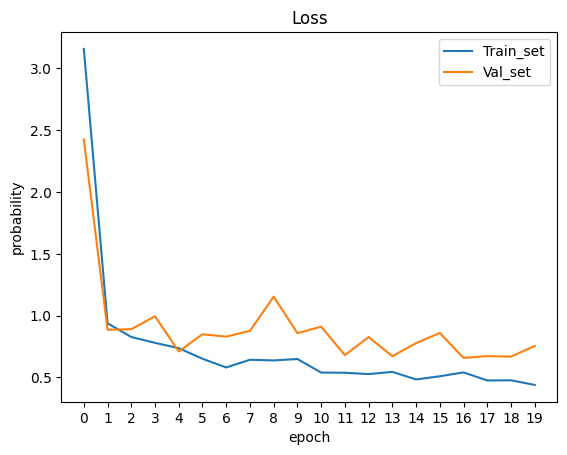

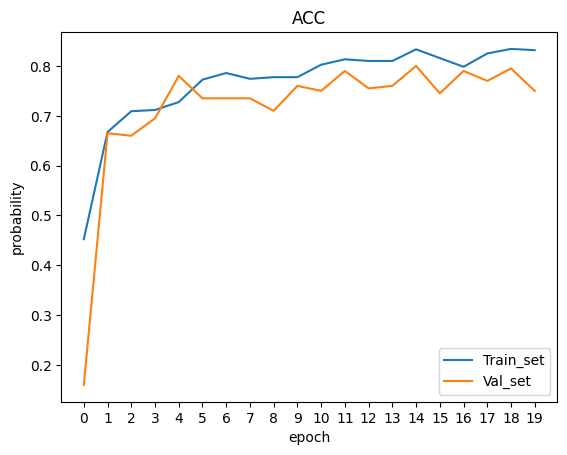

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# 经典与传统的对比
# 加载经典
# Classical_Train_data = pd.read_csv('/home/WUYING_986418966_1288354473/Desktop/QCNN/src/QCNN-FC/QTCNN-MNIST/640_train.csv')
# Classical_Val_data = pd.read_csv('/home/WUYING_986418966_1288354473/Desktop/QCNN/src/QCNN-FC/QTCNN-MNIST/2091_val.csv')

# Classical_Train_data_acc = Classical_Train_data[['Train_acc']]
# Classical_Train_data_loss = Classical_Train_data[['Train_loss']]

# Classical_Val_data_acc = Classical_Val_data[['Val_acc']]
# Classical_Val_data_loss = Classical_Val_data[['Val_loss']]
def result(acc,loss,plt1_title,plt2_title,title):     # 合并结果
    #绘图
    plt.xticks(np.arange(0,20,1))
    plt.plot(acc,label=plt1_title)
    plt.plot(loss,label=plt2_title)
    plt.title(title) 
    plt.xlabel('epoch')
    plt.ylabel('probability')
    plt.legend()   #显示标签
    plt.show()

# 加载qcnn
Qcnn_Train_data = pd.read_csv('E:\\Test\\VsCode_Test\\Jupyter notebook\\version2\\padding_crx\\FashionMNIST\\s=2\\618_train.csv')
Qcnn_Val_data = pd.read_csv('E:\\Test\\VsCode_Test\\Jupyter notebook\\version2\\padding_crx\\FashionMNIST\\s=2\\1367_val.csv')

Qcnn_Train_data_acc = Qcnn_Train_data[['Train_acc']]
Qcnn_Train_data_loss = Qcnn_Train_data[['Train_loss']]

Qcnn_Val_data_acc = Qcnn_Val_data[['Val_acc']]
Qcnn_Val_data_loss = Qcnn_Val_data[['Val_loss']]

# 损失值比较
result(Qcnn_Train_data_loss,Qcnn_Val_data_loss,'Train_set','Val_set','Loss')
# 准确率比较
result(Qcnn_Train_data_acc,Qcnn_Val_data_acc,'Train_set','Val_set','ACC')